In [1]:
import warnings
warnings.filterwarnings("ignore")

import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gzip
import Preprocessing as pproc 
import HerdingFunctions as hf
import statsmodels.api as sm
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

directory = os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

In [2]:
# Load datasets
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')

In [19]:
# Creation of the df with ALL the breweries with a unique brewery ID (chosen to be the one from RB)
unified_breweries = RB_breweries
unified_breweries = unified_breweries.rename(columns={'nbr_beers':'nbr_beers_rb'})

BA_brew = BA_breweries.add_suffix('_ba')

MB_breweries_subset = MB_breweries[['id', 'id.1', 'location', 'location.1', 'nbr_beers', 'nbr_beers.1', 'name', 'name.1']]
MB_breweries_subset = MB_breweries_subset.add_suffix('_ba')
MB_breweries_subset.columns = MB_breweries_subset.columns.str.replace('.1_ba' , '_rb')

merged_df = pd.merge(BA_brew, MB_breweries_subset, on=['id_ba', 'name_ba', 'location_ba', 'nbr_beers_ba'], how='left')
available_numbers_brew = np.setxor1d(np.arange(1,3*len(BA_brew)), unified_breweries.id.unique())
merged_df['new_ba_brew_id'] = available_numbers_brew[:len(BA_brew)]

merged_df['id'] = merged_df['id_rb'].combine_first(merged_df['new_ba_brew_id'])
merged_df['location'] = merged_df['location_rb'].combine_first(merged_df['location_ba'])
merged_df['name'] = merged_df['name_rb'].combine_first(merged_df['name_ba'])

unified_breweries = unified_breweries.merge(merged_df[['name', 'id', 'location', 'nbr_beers_ba']], on=['id', 'name', 'location'], how='outer')
unified_breweries['nbr_beers_rb'].fillna(0, inplace=True)
unified_breweries['nbr_beers_ba'].fillna(0, inplace=True)
unified_breweries['total_nbr_beers'] = unified_breweries[["nbr_beers_rb", "nbr_beers_ba"]].max(axis=1)

# Duplicated in the BA database
unified_breweries['nbr_ba'] = unified_breweries.groupby('id')['nbr_beers_ba'].transform('mean')
unified_breweries = unified_breweries.drop_duplicates('id')
unified_breweries = unified_breweries.drop('nbr_beers_ba', axis=1)
unified_breweries = unified_breweries.rename(columns={'nbr_ba':'nbr_beers_ba'})
display(unified_breweries)

,id,location,name,nbr_beers_rb,total_nbr_beers,nbr_beers_ba
0,3198.0,Gabon,Sobraga,3.0,3.0,0.0
1,13538.0,Northern Ireland,Ards Brewing Co.,13.0,13.0,7.0
2,22304.0,Northern Ireland,Barrahooley Craft Brewery,4.0,4.0,3.0
3,22818.0,Northern Ireland,Boundary,66.0,66.0,0.0
4,24297.0,Northern Ireland,Brewbot Belfast,3.0,3.0,0.0
...,...,...,...,...,...,...
32707,40943.0,Germany,Privatbrauerei Franz Joseph Sailer,0.0,6.0,6.0
32708,40944.0,Aruba,Aruba Brewing,0.0,0.0,0.0
32709,40945.0,"United States, New York",John Harvard’s Brewery & Ale House,0.0,491.0,491.0
32710,40946.0,"United States, North Carolina",Triangle Brewing Company,0.0,20.0,20.0


In [4]:
def unify_location(loc, keep_state=False):
    '''
        Unify all states in the US as one country
    '''
    if not keep_state:
        return 'United States' if loc.startswith('United States') else loc
    else: 
        if loc.startswith('United States'):
            return loc.split(',')[1]
        else: 
            return loc

In [20]:
# Filter the datasets and remove breweries for which the number of beers associated to them is zero
unified_breweries = unified_breweries[unified_breweries['total_nbr_beers']>=1].copy(deep=True)
display(unified_breweries)

,id,location,name,nbr_beers_rb,total_nbr_beers,nbr_beers_ba
0,3198.0,Gabon,Sobraga,3.0,3.0,0.0
1,13538.0,Northern Ireland,Ards Brewing Co.,13.0,13.0,7.0
2,22304.0,Northern Ireland,Barrahooley Craft Brewery,4.0,4.0,3.0
3,22818.0,Northern Ireland,Boundary,66.0,66.0,0.0
4,24297.0,Northern Ireland,Brewbot Belfast,3.0,3.0,0.0
...,...,...,...,...,...,...
32701,40930.0,"United States, North Carolina",White Rabbit Brewing Company,0.0,18.0,18.0
32704,40938.0,"United States, California",Farmhouse Brewing Co.,0.0,4.0,4.0
32707,40943.0,Germany,Privatbrauerei Franz Joseph Sailer,0.0,6.0,6.0
32709,40945.0,"United States, New York",John Harvard’s Brewery & Ale House,0.0,491.0,491.0


In [21]:
# Unify all states in the US as one country - United States for the three datasets
unified_breweries['location'] = unified_breweries['location'].apply(unify_location)

In [42]:
# Define set of brewery ids that are present in BA and RB datasets but not in the matched dataset
#non_common_BA = set(BA_breweries_filt['id']) - set(MB_breweries_filt['id'])
#non_common_RB = set(RB_breweries_filt['id']) - set(MB_breweries_filt['id'])

# Add the missing breweries to the matched dataset, keeping same RB vs BA format
#breweries_data = pd.concat([MB_breweries_filt, BA_breweries_filt[BA_breweries_filt['id'].isin(non_common_BA)]], )
#breweries_data = pd.concat([breweries_data, RB_breweries_filt[RB_breweries_filt['id'].isin(non_common_RB)].add_suffix('.1')], )

# For breweries with different number of beers between BA and RB datasets, define the highest number
#breweries_data['max_nbr_beers'] = breweries_data[['nbr_beers','nbr_beers.1']].apply(max, axis=1)

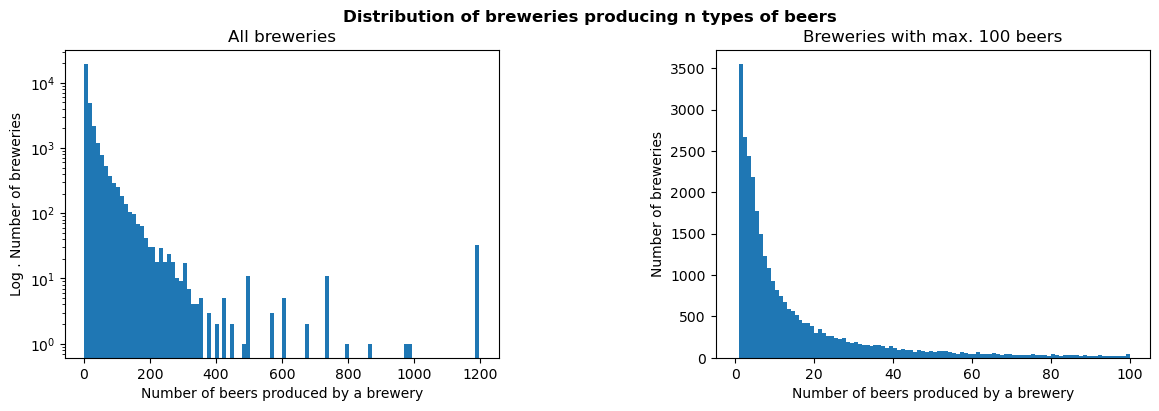

In [30]:
# Histograms showing the complete distribution of the number of beers per brewery on the left and the number of breweries producing up to 100 beers on the right
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

unified_breweries['total_nbr_beers'].sort_values().plot(kind='hist', bins= 100, ax=axs[0])
axs[0].set_xlabel('Number of beers produced by a brewery')
axs[0].set_ylabel('Log . Number of breweries')
axs[0].set_yscale('log')
axs[0].set_title('All breweries')

unified_breweries['total_nbr_beers'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[1])
axs[1].set_xlabel('Number of beers produced by a brewery')
axs[1].set_ylabel('Number of breweries')
axs[1].set_title('Breweries with max. 100 beers')

fig.suptitle('Distribution of breweries producing n types of beers', weight='bold')

plt.show()

In [23]:
# Here we define the threshold for local vs industrial breweries
# Local breweries < 15
# Industrial breweries > 15
unified_breweries['local_brewery'] = unified_breweries['total_nbr_beers'].apply(lambda x: True if x < 15 else False)

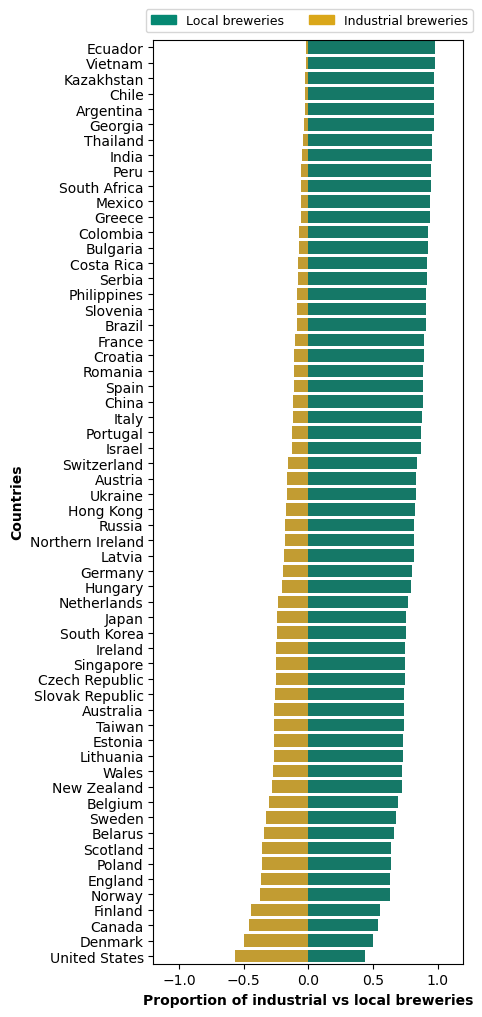

In [31]:
# Plotting the proportion of local vs industrial breweries per country
# We filtered out countries having less than 30 breweries for better statistics
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(4, 12))

grouped = unified_breweries.groupby('location').agg({
    'local_brewery': lambda x: x.mean(),
    'name': 'size'
}).reset_index()
grouped.sort_values(by='local_brewery', ascending=False, inplace=True)
grouped['industrial_brewery'] = grouped['local_brewery'] - 1
grouped = grouped[grouped['name'] > 30]

sns.barplot(data=grouped, y='location', x='local_brewery', color='#058872')
sns.barplot(data=grouped, y='location', x='industrial_brewery', color='#DAA71A')

local_patch = mpatches.Patch(color='#058872', label='Local breweries')
industrial_patch = mpatches.Patch(color='#DAA71A', label='Industrial breweries')
plt.legend(handles=[local_patch, industrial_patch], bbox_to_anchor=(1.05, 1.04), fontsize='9', ncol=2)
plt.ylabel('Countries', weight='bold')
plt.xlabel('Proportion of industrial vs local breweries', weight='bold')
#plt.legend(labels=["Local breweries","Industrial breweries"], loc='upper left', labelcolor=['#058872', '#DAA71A'], fontsize='small')
plt.xlim(-1.2,1.2)
plt.show()

In [25]:
# Filtered out countries having less than 30 breweries for better statistics
country_to_keep = grouped[grouped['name'] > 30]['location']

unified_breweries_filt = unified_breweries[unified_breweries['location'].isin(country_to_keep)]
unified_breweries_filt

,id,location,name,nbr_beers_rb,total_nbr_beers,nbr_beers_ba,local_brewery
1,13538.0,Northern Ireland,Ards Brewing Co.,13.0,13.0,7.0,True
2,22304.0,Northern Ireland,Barrahooley Craft Brewery,4.0,4.0,3.0,True
3,22818.0,Northern Ireland,Boundary,66.0,66.0,0.0,False
4,24297.0,Northern Ireland,Brewbot Belfast,3.0,3.0,0.0,True
5,27006.0,Northern Ireland,Bullhouse Brewing Company,6.0,6.0,6.0,True
...,...,...,...,...,...,...,...
32701,40930.0,United States,White Rabbit Brewing Company,0.0,18.0,18.0,False
32704,40938.0,United States,Farmhouse Brewing Co.,0.0,4.0,4.0,True
32707,40943.0,Germany,Privatbrauerei Franz Joseph Sailer,0.0,6.0,6.0,True
32709,40945.0,United States,John Harvard’s Brewery & Ale House,0.0,491.0,491.0,False
